In [1]:
import pandas as pd
import numpy as np
import os
import tsfresh
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support
import tensorflow as tf
import seaborn as sns
from datetime import datetime
from imblearn.over_sampling import RandomOverSampler

import os

import matplotlib.pyplot as plt

# keras goodies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv1D, Dropout, MaxPooling1D, BatchNormalization, Conv2D, Bidirectional, LSTM, TimeDistributed
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import metrics as kmetrics
import tensorflow.keras.backend as K

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate

In [2]:
window_size = 25
tf.random.set_seed(1)
np.random.seed(1)

## Getting the data

Before you run this, make sure that you have generated a sliding_windows file by running 01_sliding_windows.

In [3]:
data_path = '../data/'

In [4]:
final_sliding_windows_thingy = pd.read_csv(data_path + '/latest_sliding_windows_Thingy_smooth0_smallest25_size25_step25.csv')
#final_sliding_windows_respeck = pd.read_csv(data_path + '/sliding_windows_Respeck_smallest25_size25_step25.csv')

#smooth3_final_sliding_windows_respeck = pd.read_csv(data_path + '/sliding_windows_Respeck_smooth3_smallest25_size25_step25.csv')
#smooth3_final_sliding_windows_thingy = pd.read_csv(data_path + '/sliding_windows_Thingy_smooth3_smallest25_size25_step25.csv')

#smooth5_final_sliding_windows_respeck = pd.read_csv(data_path + '/sliding_windows_Respeck_smooth5_smallest25_size25_step25.csv')
#smooth5_final_sliding_windows_thingy = pd.read_csv(data_path + '/sliding_windows_Thingy_smooth5_smallest25_size25_step25.csv')

#smooth7_final_sliding_windows_respeck = pd.read_csv(data_path + '/sliding_windows_Respeck_smooth7_smallest25_size25_step25.csv')
#smooth7_final_sliding_windows_thingy = pd.read_csv(data_path + '/sliding_windows_Thingy_smooth7_smallest25_size25_step25.csv')

In [6]:
#smooth9_final_sliding_windows_respeck = pd.read_csv(data_path + '/sliding_windows_Respeck_smooth9_smallest25_size25_step25.csv')
#smooth9_final_sliding_windows_thingy = pd.read_csv(data_path + '/sliding_windows_Thingy_smooth9_smallest25_size25_step25.csv')

In [6]:
def plot_by_id(df, i): 
    plot_recording = df[df['recording_id'] == i]
    plot_recording = plot_recording.reset_index()
    plt.plot(plot_recording.index, plot_recording['accel_x'])
    plt.plot(plot_recording.index, plot_recording['accel_y'])
    plt.plot(plot_recording.index, plot_recording['accel_z'])
    
# plot_by_id(final_sliding_windows_respeck, 'Respeck_s1541031_Climbing stairs_06-10-2021_11-25-43')
#plot_by_id(smooth7_final_sliding_windows_thingy, 'Thingy_s1541031_Climbing stairs_06-10-2021_11-27-07')

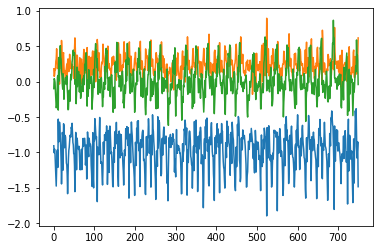

In [7]:
# plot_by_id(smooth7_final_sliding_windows_respeck, 'Respeck_s1541031_Climbing stairs_06-10-2021_11-25-43')
plot_by_id(final_sliding_windows_thingy, 'Thingy_s1541031_Climbing stairs_06-10-2021_11-27-07')

In [38]:
# How many stduents recorded the falling activities?
falling_activities = [ac for ac in final_sliding_windows_thingy['activity_type'].unique() if 'Falling' in ac]
students = []
for f in falling_activities:
    f_df = final_sliding_windows_thingy[final_sliding_windows_thingy['activity_type'] == f]
    students += list(f_df['subject_id'].unique())
    print('{} has {} students'.format(f,len(f_df['subject_id'].unique())))
len(np.unique(students))

Falling on knees has 45 students
Falling on the back has 44 students
Falling on the left has 44 students
Falling on the right has 45 students


45

In [39]:
# What about the cleaned dataset?
#clean_sliding_windows_thingy = pd.read_csv(data_path + '/clean_sliding_windows_Thingy_smooth0_smallest25_size25_step25.csv')
#falling_activities = [ac for ac in clean_sliding_windows_thingy['activity_type'].unique() if 'Falling' in ac]
#students = []
#for f in falling_activities:
#    f_df = clean_sliding_windows_thingy[clean_sliding_windows_thingy['activity_type'] == f]
#    students += list(f_df['subject_id'].unique())
#    print(f_df['subject_id'].unique())
#    print('{} has {} students'.format(f,len(f_df['subject_id'].unique())))
#len(np.unique(students))

['s1704145' 's2119637' 's2171825' 's2173036']
Falling on the left has 4 students
['s1826390' 's2119637' 's2171825' 's2173036']
Falling on knees has 4 students
['s1894401' 's2119637' 's2171825' 's2173036']
Falling on the back has 4 students
['s2119637' 's2171825' 's2173036']
Falling on the right has 3 students


6

## Some definitions

### Prepping the CNN model

In [7]:
def prep_cnn():
    print("Prepping CNN...")
    
    filters = 64
    kernel_size = 3
    n_features = 6
    activation ='relu'
    n_classes = len(class_labels)
    #filters = [3, 7, 11]

    model = Sequential()

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear', 
                     input_shape=(window_size, n_features)))
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    #model.summary()
    
    model.compile(
    optimizer=optimizers.Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics = ['accuracy'])
    
    print("CNN prepped.")
    
    return model

In [10]:
# Wan et al. also used sinwod size 25, good for borrowing arch

def wan_cnn(save_to=None):
    """The kernel_sizes of each convolutional layer and pooling layer are 7, 3 and 1, 
    and the convolution depth (depth_size) is 64 steps, stride_size= 3, and batch_size= 64. 
    The number of hidden units in the fully connected layer is 512. During the training, 
    we used a dropout layer with the following parameters to prevent overfitting: 0.1, 0.25 and 0.5."""
    
    kernels = [7,3,1]
    dropouts = [0.1,0.25,0.5]
    f=64
    n_features = 6
    n_classes = len(class_labels)
    s=6
    
    model = Sequential()

    model.add(Conv1D(filters=f, kernel_size=kernels[0],
                     input_shape=(window_size, n_features)))
    #They don't mention activation method
    model.add(MaxPooling1D())
    model.add(Dropout(dropouts[0]))
    
    model.add(Conv1D(filters=f, kernel_size=kernels[1]))
    model.add(MaxPooling1D())
    model.add(Dropout(dropouts[1]))
    
    model.add(Conv1D(filters=f, kernel_size=kernels[2]))
    model.add(MaxPooling1D())
    model.add(Dropout(dropouts[2]))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001), metrics=['accuracy'], strides=s)
    
    #save_to_models_comparisons('wan_et_al.txt', model.summary())
    print(model.summary())
    
    return model

In [5]:
def promising_cnn(learning_rate=0.001, filters=64, kernel_size=2):
    n_features = 6
    activation ='relu'
    n_classes = len(class_labels)

    model = Sequential()

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, 
                     input_shape=(window_size, n_features)))
    model.add(MaxPooling1D())
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation))
    model.add(MaxPooling1D())
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation))
    #model.add(MaxPooling1D())
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    model.summary()

    model.compile(
            optimizer=optimizers.Adam(lr=learning_rate),
            loss='categorical_crossentropy',
            metrics = ['accuracy'])
    
    return model

In [20]:
promising_cnn()

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_96 (Conv1D)           (None, 23, 64)            1216      
_________________________________________________________________
max_pooling1d_96 (MaxPooling (None, 11, 64)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 11, 64)            256       
_________________________________________________________________
activation (Activation)      (None, 11, 64)            0         
_________________________________________________________________
conv1d_97 (Conv1D)           (None, 9, 64)             12352     
_________________________________________________________________
max_pooling1d_97 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 64)           

In [12]:
def promising_cnn_tinkering(filters=64, kernel_size=3):
    filters = filters
    kernel_size = kernel_size
    n_features = 6
    activation ='relu'
    n_classes = len(class_labels)

    model = Sequential()

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, 
                     input_shape=(window_size, n_features)))
    model.add(MaxPooling1D())

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation))
    model.add(MaxPooling1D())

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation))
    model.add(MaxPooling1D())

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    model.summary()

    model.compile(
            optimizer=optimizers.Adam(lr=0.001),
            loss='categorical_crossentropy',
            metrics = ['accuracy'])
    
    return model

In [5]:
def try_lstm(lstm_units=128, nn_units=128, dropout=0.5, learning_rate=0.01):
    n_features = 6
    n_classes = len(class_labels)
    
    model = Sequential()
    model.add(
        Bidirectional(
          LSTM(
              units=lstm_units,
              input_shape=(window_size, n_features)
          )
        )
    )
    model.add(Dropout(rate=dropout))
    model.add(Dense(units=nn_units, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(
      loss='categorical_crossentropy',
      optimizer=optimizers.Adam(lr=learning_rate),
      metrics=['acc']
    )
    
    return model

In [14]:
def cnn_lstm():
    filters = 64
    kernel_size = 3
    n_features = 6
    activation ='relu'
    n_classes = len(class_labels)
    
    # define CNN model
    cnn = Sequential()
    cnn.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, 
                     input_shape=(window_size, n_features)))
    cnn.add(MaxPooling1D())
    cnn.add(Flatten())
    
    # define LSTM model
    model = Sequential()
    model.add(TimeDistributed(cnn))
    """
    model.add(
        Bidirectional(
          LSTM(
              units=128,
              input_shape=(1,704)
          )
        )
    )
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    
    model.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=['acc']
    )
    """
    
    return cnn

In [5]:
def try_cnn_lstm(filters=64, kernel_size=3, learning_rate=0.001, lstm_units=128, nn_units=128, dropout=0.5):
    n_features = 6
    activation ='relu'
    n_classes = len(class_labels)
    
    model = Sequential([
          Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, 
                     input_shape=(window_size, n_features)),
        MaxPooling1D(),
        Conv1D(filters=filters, kernel_size=kernel_size, activation=activation),
        MaxPooling1D(),
           Bidirectional(LSTM(units=lstm_units)),
        Flatten(),
        Dropout(rate=dropout),
          Dense(units=nn_units, activation='relu'),
        Dense(n_classes, activation='softmax')])
    
    model.compile(
      loss='categorical_crossentropy',
      optimizer=optimizers.Adam(lr=learning_rate),
      metrics=['acc']
    )
    
    return model

In [16]:
# multi-headed cnn model
# https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/

def multi_head_cnn(trainX, trainy, testX, testy):
    k1_size, k2_size, k3_size = 3, 5, 11 # 56 / 86
#     k1_size, k2_size, k3_size = 2, 3, 7 # 59 / 89
    filters = 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # head 1
    inputs1 = Input(shape=(n_timesteps,n_features))
    conv1 = Conv1D(filters=filters, kernel_size=k1_size, activation='relu')(inputs1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # head 2
    inputs2 = Input(shape=(n_timesteps,n_features))
    conv2 = Conv1D(filters=filters, kernel_size=k2_size, activation='relu')(inputs2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # head 3
    inputs3 = Input(shape=(n_timesteps,n_features))
    conv3 = Conv1D(filters=filters, kernel_size=k3_size, activation='relu')(inputs3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(100, activation='relu')(merged)
    outputs = Dense(n_outputs, activation='softmax')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    
    model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [17]:
def save_to_models_comparisons(save_to, text):
    model_dir = 'models/comparisons/'
    
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir)
        
    f = open(model_dir + save_to, "a")
    f.write(text)
    f.close()

### Format the input

Format data into windows - make (window_size,6) inputs

In [6]:
columns_of_interest = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

In [7]:
class_labels = {
    'Sitting': 0,
    'Sitting bent forward': 1,
    'Sitting bent backward': 2,
    'Standing': 3,
    'Lying down left': 4,
    'Lying down right': 5,
    'Lying down on stomach': 6,
    'Lying down on back': 7,
    'Walking at normal speed': 8,
    'Running': 9,
    'Climbing stairs': 10,
    'Descending stairs': 11,
    'Desk work': 12,
    'Movement': 13,
    'Falling on knees': 14,
    'Falling on the back': 15,
    'Falling on the left': 16,
    'Falling on the right': 17
}

In [8]:
def format_data(X_train_full, y_train_full, X_test_full, y_test_full):
    
    print("Formatting data...")
    # Keep only the classes of interest
#     X_train_full = X_train_full[y_train_full['activity_type'].isin(class_labels.keys())]
#     X_test_full = X_test_full[y_test_full['activity_type'].isin(class_labels.keys())]
#     y_train_full = y_train_full[y_train_full['activity_type'].isin(class_labels.keys())]
#     y_test_full = y_test_full[y_test_full['activity_type'].isin(class_labels.keys())]

    # Create the y ones
    y_train = y_train_full.groupby("window_id")[['activity_type']].agg(np.min).replace(class_labels)['activity_type'].values
    y_test = y_test_full.groupby("window_id")[['activity_type']].agg(np.min).replace(class_labels)['activity_type'].values
    y_train = np.asarray(pd.get_dummies(y_train), dtype=np.float32)
    y_test = np.asarray(pd.get_dummies(y_test), dtype=np.float32)
    
    X_train = []
    X_test = []

    for window_id, group in X_train_full.groupby('window_id'):
        #print(f"window_id = {window_id}")

        shape = group[columns_of_interest].values.shape
        #print(f"shape = {shape}")
        if shape == (window_size, len(columns_of_interest)):
            X_train.append(group[columns_of_interest].values)

    for window_id, group in X_test_full.groupby('window_id'):
        #print(f"window_id = {window_id}")

        shape = group[columns_of_interest].values.shape
        #print(f"shape = {shape}")

        X_test.append(group[columns_of_interest].values)

    X_train = np.asarray(X_train)#, dtype=object)
    X_test = np.asarray(X_test)#, dtype=object)
    
    print(np.shape(X_train))
    print(np.shape(X_test))

    print(np.shape(y_train))
    print(np.shape(y_test))
    
    print("Data formatted.")
    return X_train, y_train, X_test, y_test

In [9]:
def format_all_data(X_train_full, y_train_full):
    # to be used when we only want a training set not test set
    
    print("Formatting data...")
    # Keep only the classes of interest
#     X_train_full = X_train_full[y_train_full['activity_type'].isin(class_labels.keys())]
#     y_train_full = y_train_full[y_train_full['activity_type'].isin(class_labels.keys())]

    # Create the y ones
    y_train = y_train_full.groupby("window_id")[['activity_type']].agg(np.min).replace(class_labels)['activity_type'].values
    y_train = np.asarray(pd.get_dummies(y_train), dtype=np.float32)
    
    X_train = []

    for window_id, group in X_train_full.groupby('window_id'):
        #print(f"window_id = {window_id}")

        shape = group[columns_of_interest].values.shape
        #print(f"shape = {shape}")
        if shape == (window_size,len(columns_of_interest)):
            X_train.append(group[columns_of_interest].values)

    X_train = np.asarray(X_train)#, dtype=object)
    
    print(np.shape(X_train))
    print(np.shape(y_train))
    
    print("Data formatted.")
    return X_train, y_train

### Accuracy of the model (+ on subset)

In [10]:
# This is used for grouping the predictions into subsets
activity_groups = {
 'Sitting/Standing': [0,1,2,3,12], # including desk work
 'Lying': [4,5,6,7],
 'Walking': [8,10,11,13], # I include up and down stairs in this one + movement
 'Running': [9],
 'Falling': [14,15,16,17]
}

def group_y(y):
    grouped_y = []
    for yy in y:
        group = [i for i,v in enumerate(activity_groups.values()) if yy in v][0]
        grouped_y.append(group)
    return grouped_y

In [11]:
def evaluate(y_true_labels, y_pred_labels, save_to=None):
    print('\n')
    print("*" * 80)
    print("Classification report")
    print("*" * 80)
    print(classification_report(y_true_labels, y_pred_labels, target_names=list(class_labels.keys())))
    
    # compute accuracy of the subset of activities 
    grouped_y_true_labels = group_y(y_true_labels)
    grouped_y_pred_labels = group_y(y_pred_labels)

    print('\n')
    print("*" * 80)
    print("Classification report")
    print("*" * 80)
    print(classification_report(grouped_y_true_labels, grouped_y_pred_labels, target_names=list(activity_groups.keys())))

In [21]:
def print_scores(y_true, y_pred, categories):
    conf_mat = confusion_matrix(y_true, y_pred)
    accuracies = conf_mat.diagonal()/conf_mat.sum(axis=1)
    precisions, recalls, fscores, _ = precision_recall_fscore_support(y_true, y_pred)

    max_length = max([len(key) for key in categories])
    for i, cl in enumerate(categories):
        n_dots = max_length + 5 -len(cl)
        print(cl + n_dots * '.' + ' Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F-score: {:.2f}\n'.format(
                accuracies[i], precisions[i], recalls[i], fscores[i]))

In [31]:
def confusion_mat(y_true_labels, y_pred_labels, labels = class_labels.keys(), title='Confusion matrix', figsize=(10,7)):
    cm = confusion_matrix(y_true_labels, y_pred_labels,normalize='true')
    cm = np.around(cm, 2)

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, 
                ax=ax, fmt='.2g', vmin=0, vmax=1, cbar_kws={'label': 'Accuracy'}, annot_kws={"size": 9})
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    plt.show()

In [ ]:
confusion_mat(y_t, y_p)

## Without Cross-validation for development

In [14]:
def prep_dev_data(final_sliding_windows):

    # split data into training and test sets (split by subject)

    subjects = final_sliding_windows['subject_id'].unique()

    train_subjects, test_subjects = train_test_split(subjects, test_size=0.2, train_size=0.8)

    X_train_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(train_subjects)][['window_id'] + columns_of_interest]
    y_train_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(train_subjects)][['window_id'] + ['activity_type']]
    
    X_test_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(test_subjects)][['window_id'] + columns_of_interest]
    y_test_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(test_subjects)][['window_id'] + ['activity_type']]
    
    # format the data
    X_train, y_train, X_test, y_test = format_data(X_train_full, y_train_full, X_test_full, y_test_full)
    
    return X_train, y_train, X_test, y_test

In [58]:
X_train_full = final_sliding_windows_thingy[['window_id'] + columns_of_interest]
y_train_full = final_sliding_windows_thingy[['window_id'] + ['activity_type']]

In [60]:
y_train_full

,window_id,activity_type
0,0,Climbing stairs
1,0,Climbing stairs
2,0,Climbing stairs
3,0,Climbing stairs
4,0,Climbing stairs
...,...,...
572720,22908,Walking at normal speed
572721,22908,Walking at normal speed
572722,22908,Walking at normal speed
572723,22908,Walking at normal speed


In [46]:
def train_dev_model(model, X_train, y_train, batch_size=100, epochs=10):

    # train the model 
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
    
    return model

In [48]:
# Prep data
X_train, y_train, X_test, y_test = prep_dev_data(final_sliding_windows_thingy)

Formatting data...
(19625, 25, 6)
(4425, 25, 6)
(19625, 18)
(4425, 18)
Data formatted.


In [49]:
# # Prep data
# X_train, y_train, X_test, y_test = prep_dev_data(final_sliding_windows_thingy)

# prepare the model
model = promising_cnn()
# model = multi_head_cnn(X_train, y_train, X_test, y_test)

# Train 
model = train_dev_model(model, X_train, y_train, batch_size=64, epochs=10)
#train multi head cnn - 3 inputs
# model = train_dev_model(model, [X_train, X_train, X_train], y_train, batch_size=64, epochs=10)    

# Test the model
y_pred_ohe = model.predict(X_test)
# test multi head cnn - 3 inputs
# y_pred_ohe = model.predict([X_test, X_test, X_test])
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

evaluate(y_true_labels, y_pred_labels)

Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_261 (Conv1D)          (None, 24, 64)            832       
_________________________________________________________________
max_pooling1d_174 (MaxPoolin (None, 12, 64)            0         
_________________________________________________________________
batch_normalization_261 (Bat (None, 12, 64)            256       
_________________________________________________________________
activation_261 (Activation)  (None, 12, 64)            0         
_________________________________________________________________
conv1d_262 (Conv1D)          (None, 11, 64)            8256      
_________________________________________________________________
max_pooling1d_175 (MaxPoolin (None, 5, 64)             0         
_________________________________________________________________
batch_normalization_262 (Bat (None, 5, 64)           

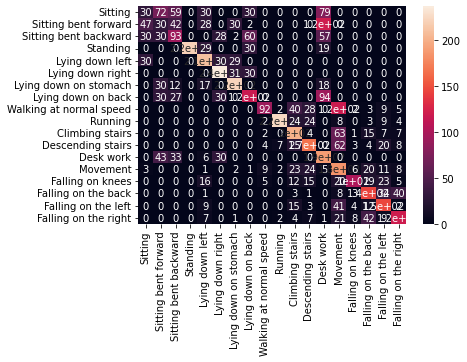

In [100]:
confusion_mat(y_true_labels, y_pred_labels)

## Train baseline model on ALL data

In [19]:
# Note: On Thingy
X = final_sliding_windows_thingy[['window_id'] + columns_of_interest]
y = final_sliding_windows_thingy[['window_id'] + ['activity_type']]

# format the data
X_train, y_train = format_all_data(X, y)
   
# prepare the CNN
model = try_cnn_lstm(lstm_units=128, nn_units=64, filters=32, kernel_size=2, learning_rate=0.001)

# train the model 
train_dev_model(model, X_train, y_train, batch_size=64, epochs=5)

Formatting data...
(22909, 25, 6)
(22909, 18)
Data formatted.
Train on 22909 samples
Epoch 1/5
22909/22909 [==============================] - 10s 425us/sample - loss: 1.5813 - acc: 0.4558
Epoch 2/5
22909/22909 [==============================] - 5s 205us/sample - loss: 1.1947 - acc: 0.5734
Epoch 3/5
22909/22909 [==============================] - 5s 225us/sample - loss: 1.0689 - acc: 0.6140
Epoch 4/5
22909/22909 [==============================] - 5s 214us/sample - loss: 0.9961 - acc: 0.6339s - los - ETA: 1s - loss: 0.99 - ETA: 0s - loss: 0.9968 - acc:  - ETA: 0s - loss: 0.9955 - acc: 0.633
Epoch 5/5
22909/22909 [==============================] - 5s 216us/sample - loss: 0.9268 - acc: 0.6614


## Leave-One-Subject-Out Cross Validation

In [15]:
def get_loocv(final_sliding_windows, n=6):

    loocv = LeaveOneGroupOut()

    # # UNCOMMENT TO LEAVE ONE SUBJECT OUT####
    # # group by subject id so that one subject is left out each time
    # groups = final_sliding_windows['subject_id']
    # ########################################

    # UNCOMMENT TO LEAVE (48 / N) SUBJECTS OUT####
    # n must be a factor of 48 (there are 48 subjects in the dataset)
    #n = 6
    subj_group_mapping = {}
    for i, subj_id in enumerate(final_sliding_windows['subject_id'].unique()):
        subj_group_mapping[subj_id] = i % n
    groups = [ subj_group_mapping[subj_id] for subj_id in final_sliding_windows['subject_id'] ]
    ########################################

    X = final_sliding_windows[['window_id'] + columns_of_interest]
    y = final_sliding_windows[['window_id'] + ['activity_type']]

    # how many different subjects
    loocv.get_n_splits(X, y, groups)
    
    return loocv, X, y, groups

In [18]:
def run_cross_val(final_sliding_windows, model_setup, params={}, n=4,  batch_size=32, epochs=10, oversample=False, verbose=0):
    loocv, X, y, groups = get_loocv(final_sliding_windows, n=n)

    y_pred_labels = np.empty(shape=(0,))
    y_true_labels = np.empty(shape=(0,))
    
    trained_models = [] # For epoch experiments

    # this gives a train/test split that leaves one subject out in each iteration
    for i, (train_index, test_index) in enumerate(loocv.split(X, y, groups)):
        print("Starting iteration " + str(i) + ' of ' + str(n))

        X_train_full, X_test_full = X.iloc[train_index], X.iloc[test_index]
        y_train_full, y_test_full = y.iloc[train_index], y.iloc[test_index]

        X_train, y_train, X_test, y_test = format_data(X_train_full, y_train_full, X_test_full, y_test_full)
        if oversample:
            # Over sample only training set
            oversample = RandomOverSampler('auto')
            #X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
            oversample.fit_resample(X_train[:,:,0], np.argmax(y_train, axis=1))
            X_train = X_train[oversample.sample_indices_]
            y_train = y_train[oversample.sample_indices_]

        model = model_setup(**params)

        print("Training...")
        trained = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=verbose)
        trained_models.append(trained)
        
        # stats
        y_pred_ohe = model.predict(X_test)
        y_pred_labels = np.concatenate([y_pred_labels, np.argmax(y_pred_ohe, axis=1)])
        y_true_labels = np.concatenate([y_true_labels, np.argmax(y_test, axis=1)])

        print(y_pred_labels.shape)
        print(y_true_labels.shape)

    evaluate(y_true_labels, y_pred_labels)
    
    print_scores(y_true_labels, y_pred_labels, class_labels)
    
    grouped_y_true_labels = group_y(y_true_labels)
    grouped_y_pred_labels = group_y(y_pred_labels)
    
    print_scores(grouped_y_true_labels, grouped_y_pred_labels, activity_groups)
    
    confusion_mat(y_true_labels, y_pred_labels)
    
    return y_true_labels, y_pred_labels#, trained_models 

Starting iteration 0 of 48
Formatting data...
(23533, 25, 6)
(517, 25, 6)
(23533, 18)
(517, 18)
Data formatted.
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_111 (Conv1D)          (None, 24, 64)            832       
_________________________________________________________________
max_pooling1d_74 (MaxPooling (None, 12, 64)            0         
_________________________________________________________________
batch_normalization_111 (Bat (None, 12, 64)            256       
_________________________________________________________________
activation_111 (Activation)  (None, 12, 64)            0         
_________________________________________________________________
conv1d_112 (Conv1D)          (None, 11, 64)            8256      
_________________________________________________________________
max_pooling1d_75 (MaxPooling (None, 5, 64)             0         
_______

(2071,)
(2071,)
Starting iteration 4 of 48
Formatting data...
(23630, 25, 6)
(420, 25, 6)
(23630, 18)
(420, 14)
Data formatted.
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_123 (Conv1D)          (None, 24, 64)            832       
_________________________________________________________________
max_pooling1d_82 (MaxPooling (None, 12, 64)            0         
_________________________________________________________________
batch_normalization_123 (Bat (None, 12, 64)            256       
_________________________________________________________________
activation_123 (Activation)  (None, 12, 64)            0         
_________________________________________________________________
conv1d_124 (Conv1D)          (None, 11, 64)            8256      
_________________________________________________________________
max_pooling1d_83 (MaxPooling (None, 5, 64)             0 

(4062,)
(4062,)
Starting iteration 8 of 48
Formatting data...
(23536, 25, 6)
(514, 25, 6)
(23536, 18)
(514, 18)
Data formatted.
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_135 (Conv1D)          (None, 24, 64)            832       
_________________________________________________________________
max_pooling1d_90 (MaxPooling (None, 12, 64)            0         
_________________________________________________________________
batch_normalization_135 (Bat (None, 12, 64)            256       
_________________________________________________________________
activation_135 (Activation)  (None, 12, 64)            0         
_________________________________________________________________
conv1d_136 (Conv1D)          (None, 11, 64)            8256      
_________________________________________________________________
max_pooling1d_91 (MaxPooling (None, 5, 64)             0 

(6105,)
(6105,)
Starting iteration 12 of 48
Formatting data...
(23513, 25, 6)
(537, 25, 6)
(23513, 18)
(537, 18)
Data formatted.
Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_147 (Conv1D)          (None, 24, 64)            832       
_________________________________________________________________
max_pooling1d_98 (MaxPooling (None, 12, 64)            0         
_________________________________________________________________
batch_normalization_147 (Bat (None, 12, 64)            256       
_________________________________________________________________
activation_147 (Activation)  (None, 12, 64)            0         
_________________________________________________________________
conv1d_148 (Conv1D)          (None, 11, 64)            8256      
_________________________________________________________________
max_pooling1d_99 (MaxPooling (None, 5, 64)             0

(8149,)
(8149,)
Starting iteration 16 of 48
Formatting data...
(23555, 25, 6)
(495, 25, 6)
(23555, 18)
(495, 18)
Data formatted.
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_159 (Conv1D)          (None, 24, 64)            832       
_________________________________________________________________
max_pooling1d_106 (MaxPoolin (None, 12, 64)            0         
_________________________________________________________________
batch_normalization_159 (Bat (None, 12, 64)            256       
_________________________________________________________________
activation_159 (Activation)  (None, 12, 64)            0         
_________________________________________________________________
conv1d_160 (Conv1D)          (None, 11, 64)            8256      
_________________________________________________________________
max_pooling1d_107 (MaxPoolin (None, 5, 64)             0

(10158,)
(10158,)
Starting iteration 20 of 48
Formatting data...
(23544, 25, 6)
(506, 25, 6)
(23544, 18)
(506, 18)
Data formatted.
Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_171 (Conv1D)          (None, 24, 64)            832       
_________________________________________________________________
max_pooling1d_114 (MaxPoolin (None, 12, 64)            0         
_________________________________________________________________
batch_normalization_171 (Bat (None, 12, 64)            256       
_________________________________________________________________
activation_171 (Activation)  (None, 12, 64)            0         
_________________________________________________________________
conv1d_172 (Conv1D)          (None, 11, 64)            8256      
_________________________________________________________________
max_pooling1d_115 (MaxPoolin (None, 5, 64)            

(12221,)
(12221,)
Starting iteration 24 of 48
Formatting data...
(23541, 25, 6)
(509, 25, 6)
(23541, 18)
(509, 18)
Data formatted.
Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_183 (Conv1D)          (None, 24, 64)            832       
_________________________________________________________________
max_pooling1d_122 (MaxPoolin (None, 12, 64)            0         
_________________________________________________________________
batch_normalization_183 (Bat (None, 12, 64)            256       
_________________________________________________________________
activation_183 (Activation)  (None, 12, 64)            0         
_________________________________________________________________
conv1d_184 (Conv1D)          (None, 11, 64)            8256      
_________________________________________________________________
max_pooling1d_123 (MaxPoolin (None, 5, 64)            

Training...
(13691,)
(13691,)
Starting iteration 28 of 48
Formatting data...
(23527, 25, 6)
(523, 25, 6)
(23527, 18)
(523, 18)
Data formatted.
Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_195 (Conv1D)          (None, 24, 64)            832       
_________________________________________________________________
max_pooling1d_130 (MaxPoolin (None, 12, 64)            0         
_________________________________________________________________
batch_normalization_195 (Bat (None, 12, 64)            256       
_________________________________________________________________
activation_195 (Activation)  (None, 12, 64)            0         
_________________________________________________________________
conv1d_196 (Conv1D)          (None, 11, 64)            8256      
_________________________________________________________________
max_pooling1d_131 (MaxPoolin (None, 5, 64)

Training...
(15777,)
(15777,)
Starting iteration 32 of 48
Formatting data...
(23538, 25, 6)
(512, 25, 6)
(23538, 18)
(512, 18)
Data formatted.
Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_207 (Conv1D)          (None, 24, 64)            832       
_________________________________________________________________
max_pooling1d_138 (MaxPoolin (None, 12, 64)            0         
_________________________________________________________________
batch_normalization_207 (Bat (None, 12, 64)            256       
_________________________________________________________________
activation_207 (Activation)  (None, 12, 64)            0         
_________________________________________________________________
conv1d_208 (Conv1D)          (None, 11, 64)            8256      
_________________________________________________________________
max_pooling1d_139 (MaxPoolin (None, 5, 64)

Training...
(17852,)
(17852,)
Starting iteration 36 of 48
Formatting data...
(23548, 25, 6)
(502, 25, 6)
(23548, 18)
(502, 18)
Data formatted.
Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_219 (Conv1D)          (None, 24, 64)            832       
_________________________________________________________________
max_pooling1d_146 (MaxPoolin (None, 12, 64)            0         
_________________________________________________________________
batch_normalization_219 (Bat (None, 12, 64)            256       
_________________________________________________________________
activation_219 (Activation)  (None, 12, 64)            0         
_________________________________________________________________
conv1d_220 (Conv1D)          (None, 11, 64)            8256      
_________________________________________________________________
max_pooling1d_147 (MaxPoolin (None, 5, 64)

(19904,)
(19904,)
Starting iteration 40 of 48
Formatting data...
(23535, 25, 6)
(515, 25, 6)
(23535, 18)
(515, 18)
Data formatted.
Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_231 (Conv1D)          (None, 24, 64)            832       
_________________________________________________________________
max_pooling1d_154 (MaxPoolin (None, 12, 64)            0         
_________________________________________________________________
batch_normalization_231 (Bat (None, 12, 64)            256       
_________________________________________________________________
activation_231 (Activation)  (None, 12, 64)            0         
_________________________________________________________________
conv1d_232 (Conv1D)          (None, 11, 64)            8256      
_________________________________________________________________
max_pooling1d_155 (MaxPoolin (None, 5, 64)            

Training...
(21957,)
(21957,)
Starting iteration 44 of 48
Formatting data...
(23522, 25, 6)
(528, 25, 6)
(23522, 18)
(528, 18)
Data formatted.
Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_243 (Conv1D)          (None, 24, 64)            832       
_________________________________________________________________
max_pooling1d_162 (MaxPoolin (None, 12, 64)            0         
_________________________________________________________________
batch_normalization_243 (Bat (None, 12, 64)            256       
_________________________________________________________________
activation_243 (Activation)  (None, 12, 64)            0         
_________________________________________________________________
conv1d_244 (Conv1D)          (None, 11, 64)            8256      
_________________________________________________________________
max_pooling1d_163 (MaxPoolin (None, 5, 64)

(24050,)
(24050,)


********************************************************************************
Classification report
********************************************************************************
                         precision    recall  f1-score   support

                Sitting       0.05      0.01      0.02      1438
   Sitting bent forward       0.36      0.22      0.28      1439
  Sitting bent backward       0.29      0.36      0.32      1441
               Standing       0.75      0.91      0.82      1438
        Lying down left       0.70      0.73      0.71      1448
       Lying down right       0.81      0.81      0.81      1435
  Lying down on stomach       0.80      0.85      0.82      1450
     Lying down on back       0.43      0.69      0.53      1426
Walking at normal speed       0.72      0.66      0.69      1381
                Running       0.87      0.87      0.87      1377
        Climbing stairs       0.71      0.70      0.70      1376
      Descendin

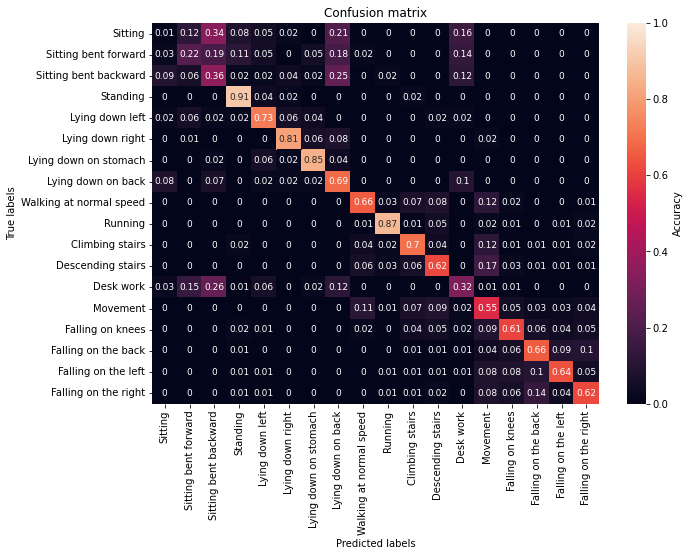

In [25]:
# Running cross-val
#params = {'lstm_units':128, 'nn_units':64, 'kernel_size':2, 'filters':32, 'learning_rate':0.001}
params = {}#{'lstm_units':64, 'nn_units':64}
y_t, y_p = run_cross_val(final_sliding_windows_thingy, promising_cnn, params, batch_size=64, epochs=10, n=48, oversample=False)

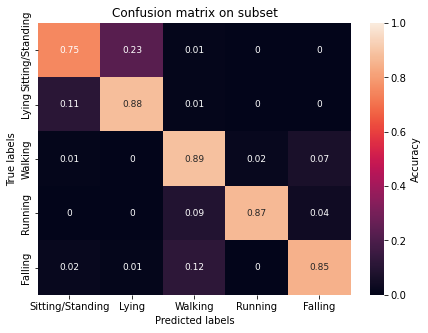

In [34]:
grouped_y_true_labels = group_y(y_t)
grouped_y_pred_labels = group_y(y_p)

confusion_mat(grouped_y_true_labels, grouped_y_pred_labels, activity_groups.keys(), 'Confusion matrix on subset', figsize=(7,5))

### For model_evaluate.py

In [129]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
conf_mat = confusion_matrix(y_t, y_p)
accuracies = conf_mat.diagonal()/conf_mat.sum(axis=1)
precisions, recalls, fscores, supports = precision_recall_fscore_support(y_t, y_p)

In [109]:
for i, cl in enumerate(class_labels):
    n_dots = 30-len(cl)
    print(cl + n_dots * '.' + ' Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F-score: {:.2f}'.format(accuracies[i], precisions[i], recalls[i], fscores[i]))

Sitting....................... Accuracy: 0.01, Precision: 0.09, Recall: 0.01, F-score: 0.02
Sitting bent forward.......... Accuracy: 0.25, Precision: 0.25, Recall: 0.25, F-score: 0.25
Sitting bent backward......... Accuracy: 0.40, Precision: 0.31, Recall: 0.40, F-score: 0.35
Standing...................... Accuracy: 0.90, Precision: 0.79, Recall: 0.90, F-score: 0.84
Lying down left............... Accuracy: 0.72, Precision: 0.74, Recall: 0.72, F-score: 0.73
Lying down right.............. Accuracy: 0.82, Precision: 0.77, Recall: 0.82, F-score: 0.80
Lying down on stomach......... Accuracy: 0.83, Precision: 0.77, Recall: 0.83, F-score: 0.80
Lying down on back............ Accuracy: 0.62, Precision: 0.33, Recall: 0.62, F-score: 0.43
Walking at normal speed....... Accuracy: 0.63, Precision: 0.69, Recall: 0.63, F-score: 0.66
Running....................... Accuracy: 0.85, Precision: 0.88, Recall: 0.85, F-score: 0.87
Climbing stairs............... Accuracy: 0.56, Precision: 0.67, Recall: 0.56, F-

In [110]:
grouped_y_t = group_y(y_t)
grouped_y_p = group_y(y_p)
conf_mat = confusion_matrix(grouped_y_t, grouped_y_p)
accuracies = conf_mat.diagonal()/conf_mat.sum(axis=1)
precisions, recalls, fscores, supports = precision_recall_fscore_support(grouped_y_t, grouped_y_p)

In [121]:
max_length = max([len(key) for key in activity_groups])
for i, cl in enumerate(activity_groups):
    n_dots = max_length + 5 -len(cl)
    print(cl + n_dots * '.' + ' Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F-score: {:.2f}'.format(accuracies[i], precisions[i], recalls[i], fscores[i]))

Sitting/Standing..... Accuracy: 0.71, Precision: 0.85, Recall: 0.71, F-score: 0.78
Lying................ Accuracy: 0.89, Precision: 0.72, Recall: 0.89, F-score: 0.79
Walking.............. Accuracy: 0.89, Precision: 0.92, Recall: 0.89, F-score: 0.90
Running.............. Accuracy: 0.85, Precision: 0.88, Recall: 0.85, F-score: 0.87
Falling.............. Accuracy: 0.44, Precision: 0.57, Recall: 0.44, F-score: 0.49


## Tuning

In [11]:
# Tuning try_lstm
kernels= [2,3]
filters = [32,64,128]
dropouts = [0.0, 0.1, 0.3, 0.5]
lstm_units = [16,32,64,128,256]
nn_units = [32,64,128,256]
batch_sizes = [64, 128]
cnn_epochs = 20
learning_rates = [0.01, 0.001]
lstm_epochs = 10
multihead_kernels = [2,3,5,7,9,11]

In [12]:
comparison_save_dir = 'models/comparisons/'

if not os.path.isdir(comparison_save_dir):
    os.mkdirs(comparison_save_dir)

### Functions and prep data

In [13]:
def get_cv_data(final_sliding_windows, n=3):
    loocv, X, y, groups = get_loocv(final_sliding_windows, n=n)

    y_pred_labels = np.empty(shape=(0,))
    y_true_labels = np.empty(shape=(0,))
    
    #trained_models = [] # For epoch experiments
    X_trains = []
    y_trains = []
    X_tests = []
    y_tests = []

    # this gives a train/test split that leaves one subject out in each iteration
    for i, (train_index, test_index) in enumerate(loocv.split(X, y, groups)):
        print("Starting iteration " + str(i) + ' of ' + str(n))

        X_train_full, X_test_full = X.iloc[train_index], X.iloc[test_index]
        y_train_full, y_test_full = y.iloc[train_index], y.iloc[test_index]

        X_train, y_train, X_test, y_test = format_data(X_train_full, y_train_full, X_test_full, y_test_full)
        
        # Yes this is very inefficient space-wise but it is to save time! 
        X_trains.append(X_train)
        y_trains.append(y_train)
        X_tests.append(X_test)
        y_tests.append(y_test)
        
        #df, trained_models = loopparas
    
    return X_trains, y_trains, X_tests, y_tests

In [14]:
def run_model_on_split(X_train, y_train, X_test, y_test, model_setup, params={}, batch_size=64, epochs=10, verbose=0):
    model = model_setup(**params)
    trained = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=verbose)

    # stats
    y_pred_ohe = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred_ohe, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)
    
    full_acc = accuracy_score(y_true_labels, y_pred_labels)
    grouped_y_true_labels = group_y(y_true_labels)
    grouped_y_pred_labels = group_y(y_pred_labels)
    subset_acc = accuracy_score(grouped_y_true_labels, grouped_y_pred_labels)
    
    return full_acc, subset_acc

In [36]:
run_model_on_split(X_trains[0], y_trains[0], X_tests[0], y_tests[0], try_lstm, epochs=3)

(0.4562859820591779, 0.7607444102289463)

In [37]:
run_model_on_split(X_trains[1], y_trains[1], X_tests[1], y_tests[1], try_lstm, epochs=3)

(0.4564108941673921, 0.7962939932844174)

In [25]:
def epoch_testing(X_train, y_train, X_test, y_test, model_setup, params={}, epochs=10, batch_size=64, verbose=0):
    model = model_setup(**params)
    trained = model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size=batch_size, epochs=epochs, verbose=verbose)
    
    return trained

In [15]:
# Get the train and test splits for each cross val
X_trains, y_trains, X_tests, y_tests = get_cv_data(final_sliding_windows_thingy)

Starting iteration 0 of 3
Formatting data...
(15440, 25, 6)
(7469, 25, 6)
(15440, 18)
(7469, 18)
Data formatted.
Starting iteration 1 of 3
Formatting data...
(14868, 25, 6)
(8041, 25, 6)
(14868, 18)
(8041, 18)
Data formatted.
Starting iteration 2 of 3
Formatting data...
(15510, 25, 6)
(7399, 25, 6)
(15510, 18)
(7399, 18)
Data formatted.


In [16]:
del final_sliding_windows_thingy

### Tune Epochs and Dropout rate

Make sure that the model setup function has defaults specified for everything!

In [26]:
# EPOCHS EXPERIMENT FOR TRY_LSTM

model_setup = try_lstm
epochs = lstm_epochs
n=3 # Must be same as used in get_cv_data!
save_file = 'try_lstm_epochs_dropouts_thingy.txt'
res = []

columns = ['title', 'data'] + ['loss' + str(j) for j in range(epochs)] + ['val_loss' + str(j) for j in range(epochs)]
columns += ['acc' + str(j) for j in range(epochs)] + ['val_acc' + str(j) for j in range(epochs)]

for dropout in dropouts:
    params = {'dropout':dropout} # Otherwise run with default parameters
    print(params)
    for i in range(n):
        print('\tData split ' + str(i) + ' @ ' + datetime.now().strftime("%H:%M:%S"))
        try:
            trained_model = epoch_testing(X_trains[i], y_trains[i], X_tests[i], y_tests[i], model_setup, verbose=0, params=params, epochs=epochs)
            
            r = []
            r += [str(params)]
            r += [i]
            r += trained_model.history['loss']
            r += trained_model.history['val_loss']
            r += trained_model.history['acc']
            r += trained_model.history['val_acc']
            
            res += [r]
        except Exception as ex:
            print('\tException: ' +  str(ex))
            
df = pd.DataFrame(res, columns=columns)
df.to_csv(comparison_save_dir + save_file)
    

{'dropout': 0.0}
	Data split 0 @ 16:54:18
	Data split 1 @ 16:58:13
	Data split 2 @ 17:02:01
{'dropout': 0.1}
	Data split 0 @ 17:06:25
	Data split 1 @ 17:10:49
	Data split 2 @ 17:16:16
{'dropout': 0.3}
	Data split 0 @ 17:27:35
	Data split 1 @ 17:37:44
	Data split 2 @ 17:46:16
{'dropout': 0.5}
	Data split 0 @ 17:56:12
	Data split 1 @ 18:06:10
	Data split 2 @ 18:16:26


In [29]:
# EPOCHS EXPERIMENT FOR TRY_CNN_LSTM

model_setup = try_cnn_lstm
epochs = lstm_epochs
n=3 # Must be same as used in get_cv_data!
save_file = 'try_cnn_lstm_epochs_dropouts_thingy.txt'
res = []

columns = ['title', 'data'] + ['loss' + str(j) for j in range(epochs)] + ['val_loss' + str(j) for j in range(epochs)]
columns += ['acc' + str(j) for j in range(epochs)] + ['val_acc' + str(j) for j in range(epochs)]

for dropout in [0.5]:
    params = {'dropout':dropout} # Otherwise run with default parameters
    print(params)
    for i in range(n):
        print('\tData split ' + str(i) + ' @ ' + datetime.now().strftime("%H:%M:%S"))
        try:
            trained_model = epoch_testing(X_trains[i], y_trains[i], X_tests[i], y_tests[i], model_setup, verbose=0, params=params, epochs=epochs)
            
            r = []
            r += [str(params)]
            r += [i]
            r += trained_model.history['loss']
            r += trained_model.history['val_loss']
            r += trained_model.history['acc']
            r += trained_model.history['val_acc']
            
            res += [r]
        except Exception as ex:
            print('\tException: ' +  str(ex))
            
df = pd.DataFrame(res, columns=columns)
df.to_csv(comparison_save_dir + save_file)
    

{'dropout': 0.5}
	Data split 0 @ 09:33:58
	Data split 1 @ 09:36:45
	Data split 2 @ 09:39:44


### Plot epoch results from file

Number of plots you should see (otherwise change rows & cols in subplots): 1


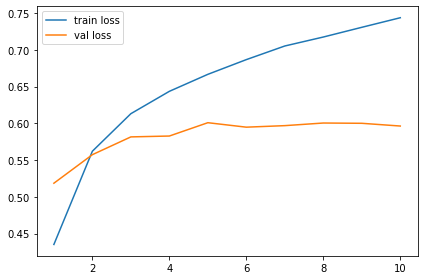

In [39]:
epoch_file = 'try_cnn_lstm_epochs_dropouts_thingy.txt'
df = pd.read_csv(comparison_save_dir + epoch_file)

def acc_plot(to_plot, ax):
    #acc_cols = [c for c in columns if c[:4] == 'loss']
    #val_acc_cols = [c for c in columns if c[:8] == 'val_loss']
    acc_cols = [c for c in columns if c[:3] == 'acc']
    val_acc_cols = [c for c in columns if c[:7] == 'val_acc']
    epochs = np.arange(len(acc_cols)) + 1

    ax.plot(epochs, df[acc_cols].mean(), label='train loss')
    ax.plot(epochs, df[val_acc_cols].mean(), label='val loss')
    ax.legend()

print('Number of plots you should see (otherwise change rows & cols in subplots): {}'.format(len(df['title'].unique())))
    
if len(df['title'].unique()) == 1:
    acc_plot(df, plt)
       
else:
    # You need to set the no. of rows and cols manually
    fig, axs = plt.subplots(2,2, figsize=(10,7)) 

    axs = axs.flatten()

    for i, title in enumerate(df['title'].unique()):
        axs[i].set_title(title)
        to_plot = df[df['title']==title]
        acc_plot(to_plot, axs[i])

    
plt.tight_layout()
plt.show()

### Tune model parameters

Make sure to run get_cv_data first

In [20]:
# MODEL PARAMETER EXPERIMENT FOR TRY_LSTM

lstm_units = [32, 64,128]
nn_units = [64,128]
batch_sizes = [64, 128]
learning_rates = [0.01,0.001]
lstm_epochs = 10

n=3 # Cross-val n used in get_cv_data
model_setup = try_lstm # Change this

# Set these from epoch experiment (Change this)
epochs = 5
dropout = 0.5
save_file = 'try_lstm_parameter_search_thingy.csv' # Change this

# Create list for saving configurations and accuracies
results = []
columns = ['epochs', 'dropout', 'lstm_unit', 'nn_units', 'batch_size', 'learning_rate'] # Change this
columns += ['acc_mean', 'sacc_mean'] # Same for all

# LSTM
# Change loops
for lstm_unit in lstm_units:
    for nn_unit in nn_units:
        for batch_size in batch_sizes:
            for learning_rate in learning_rates:
                # Change this
                params = {'dropout': dropout, 'lstm_units':lstm_unit, 'nn_units':nn_unit, 'learning_rate':learning_rate} # Params to model_setup. Batch size and learnign rate in line below
                print('\n' + str(params) + ', batch size: ' + str(batch_size))
                accs = []
                saccs = []
                for i in range(n):
                    print('\tIteration ' + str(i) + ' @ ' + datetime.now().strftime("%H:%M:%S"))
                    try:
                        acc, sacc = run_model_on_split(X_trains[i], y_trains[i], X_tests[i], y_tests[i], model_setup, params=params, batch_size=batch_size, epochs=epochs)
                        accs.append(acc)
                        saccs.append(sacc)
                        
                    except Exception as ex:
                        print('\tException: ' +  str(ex))
                    
                # Change this - must match columns!
                results.append([epochs, dropout, lstm_unit, nn_unit, batch_size, learning_rate, np.mean(accs), np.mean(saccs)])

# Save results to file
print('Saving to ' + comparison_save_dir + save_file)
df = pd.DataFrame(results, columns=columns)
df.to_csv(comparison_save_dir + save_file)


{'dropout': 0.5, 'lstm_units': 32, 'nn_units': 64, 'learning_rate': 0.01}, batch size: 64
	Iteration 0 @ 23:28:26
	Iteration 1 @ 23:28:50
	Iteration 2 @ 23:29:13

{'dropout': 0.5, 'lstm_units': 32, 'nn_units': 64, 'learning_rate': 0.001}, batch size: 64
	Iteration 0 @ 23:29:37
	Iteration 1 @ 23:30:01
	Iteration 2 @ 23:30:24

{'dropout': 0.5, 'lstm_units': 32, 'nn_units': 64, 'learning_rate': 0.01}, batch size: 128
	Iteration 0 @ 23:30:48
	Iteration 1 @ 23:31:03
	Iteration 2 @ 23:31:19

{'dropout': 0.5, 'lstm_units': 32, 'nn_units': 64, 'learning_rate': 0.001}, batch size: 128
	Iteration 0 @ 23:31:34
	Iteration 1 @ 23:31:49
	Iteration 2 @ 23:32:05

{'dropout': 0.5, 'lstm_units': 32, 'nn_units': 128, 'learning_rate': 0.01}, batch size: 64
	Iteration 0 @ 23:32:20
	Iteration 1 @ 23:32:45
	Iteration 2 @ 23:33:08

{'dropout': 0.5, 'lstm_units': 32, 'nn_units': 128, 'learning_rate': 0.001}, batch size: 64
	Iteration 0 @ 23:33:33
	Iteration 1 @ 23:33:56
	Iteration 2 @ 23:34:20

{'dropout': 0.

In [21]:
lstm_unit = 256
nn_unit = 64
learning_rate=0.001
batch_size=32
params = {'dropout': dropout, 'lstm_units':lstm_unit, 'nn_units':nn_unit, 'learning_rate':learning_rate} # Params to model_setup. Batch size and learnign rate in line below
print('\n' + str(params) + ', batch size: ' + str(batch_size))
accs = []
saccs = []
for i in range(n):
    print('\tIteration ' + str(i) + ' @ ' + datetime.now().strftime("%H:%M:%S"))
    try:
        acc, sacc = run_model_on_split(X_trains[i], y_trains[i], X_tests[i], y_tests[i], model_setup, params=params, batch_size=batch_size, epochs=epochs)
        accs.append(acc)
        saccs.append(sacc)

    except Exception as ex:
        print('\tException: ' +  str(ex))
        
minires = [epochs, dropout, lstm_unit, nn_unit, batch_size, learning_rate, np.mean(accs), np.mean(saccs)]
print(minires)


{'dropout': 0.5, 'lstm_units': 256, 'nn_units': 64, 'learning_rate': 0.001}, batch size: 32
	Iteration 0 @ 08:31:59
	Iteration 1 @ 08:51:47
	Iteration 2 @ 09:10:33
[5, 0.5, 256, 64, 32, 0.001, 0.5835694239277869, 0.8271659439920013]


In [18]:
# MODEL PARAMETER EXPERIMENT FOR TRY_CNN_LSTM

lstm_units = [32,64,128]
nn_units = [64,128]
filters = [32,64,128]
batch_sizes = [64,128]
learning_rates = [0.01,0.001]
kernels= [2,3]

n=3 # Cross-val n used in get_cv_data
model_setup = try_cnn_lstm # Change this

# Set these from epoch experiment (Change this)
epochs = 5
dropout = 0.5
save_file = 'try_cnn_lstm_parameter_search_thingy.csv' # Change this

# Create list for saving configurations and accuracies
results = []
columns = ['epochs', 'dropout', 'filters', 'kernels', 'lstm_unit', 'nn_units', 'batch_size', 'learning_rate'] # Change this
columns += ['acc_mean', 'sacc_mean'] # Same for all

# LSTM
# Change loops
for f in filters:
    for k in kernels:
        for lstm_unit in lstm_units:
            for nn_unit in nn_units:
                for batch_size in batch_sizes:
                    for learning_rate in learning_rates:
                        # Change this
                        params = {'dropout': dropout, 'lstm_units':lstm_unit, 'nn_units':nn_unit, 'kernel_size':k, 'filters':f, 'learning_rate':learning_rate} # Params to model_setup. Batch size and learnign rate in line below
                        print('\n' + str(params) + ', batch size: ' + str(batch_size))
                        accs = []
                        saccs = []
                        for i in range(n):
                            print('\tIteration ' + str(i) + ' @ ' + datetime.now().strftime("%H:%M:%S"))
                            try:
                                acc, sacc = run_model_on_split(X_trains[i], y_trains[i], X_tests[i], y_tests[i], model_setup, params=params, batch_size=batch_size, epochs=epochs)
                                accs.append(acc)
                                saccs.append(sacc)

                            except Exception as ex:
                                print('\tException: ' +  str(ex))
                                
                        # Change this - must match columns!
                        results.append([epochs, dropout, f, k, lstm_unit, nn_unit, batch_size, learning_rate, np.mean(accs), np.mean(saccs)])
                                
    print('Saving to ' + comparison_save_dir + 'temp_try_cnn_lstm_parameter_search_thingy_filter' + str(f) + 'csv')
    df = pd.DataFrame(results, columns=columns)
    df.to_csv(comparison_save_dir + save_file)

# Save results to file
print('Saving to ' + comparison_save_dir + save_file)
df = pd.DataFrame(results, columns=columns)
df.to_csv(comparison_save_dir + save_file)


{'dropout': 0.5, 'lstm_units': 32, 'nn_units': 64, 'kernel_size': 2, 'filters': 32, 'learning_rate': 0.01}, batch size: 64
	Iteration 0 @ 10:32:38
	Iteration 1 @ 10:32:52
	Iteration 2 @ 10:33:06

{'dropout': 0.5, 'lstm_units': 32, 'nn_units': 64, 'kernel_size': 2, 'filters': 32, 'learning_rate': 0.001}, batch size: 64
	Iteration 0 @ 10:33:20
	Iteration 1 @ 10:33:35
	Iteration 2 @ 10:33:49

{'dropout': 0.5, 'lstm_units': 32, 'nn_units': 64, 'kernel_size': 2, 'filters': 32, 'learning_rate': 0.01}, batch size: 128
	Iteration 0 @ 10:34:03
	Iteration 1 @ 10:34:13
	Iteration 2 @ 10:34:23

{'dropout': 0.5, 'lstm_units': 32, 'nn_units': 64, 'kernel_size': 2, 'filters': 32, 'learning_rate': 0.001}, batch size: 128
	Iteration 0 @ 10:34:34
	Iteration 1 @ 10:34:44
	Iteration 2 @ 10:34:54

{'dropout': 0.5, 'lstm_units': 32, 'nn_units': 128, 'kernel_size': 2, 'filters': 32, 'learning_rate': 0.01}, batch size: 64
	Iteration 0 @ 10:35:05
	Iteration 1 @ 10:35:18
	Iteration 2 @ 10:35:32

{'dropout': 0.

	Iteration 1 @ 11:04:45
	Iteration 2 @ 11:05:04

{'dropout': 0.5, 'lstm_units': 128, 'nn_units': 64, 'kernel_size': 3, 'filters': 32, 'learning_rate': 0.01}, batch size: 128
	Iteration 0 @ 11:05:25
	Iteration 1 @ 11:05:41
	Iteration 2 @ 11:05:56

{'dropout': 0.5, 'lstm_units': 128, 'nn_units': 64, 'kernel_size': 3, 'filters': 32, 'learning_rate': 0.001}, batch size: 128
	Iteration 0 @ 11:06:20
	Iteration 1 @ 11:07:11
	Iteration 2 @ 11:07:57

{'dropout': 0.5, 'lstm_units': 128, 'nn_units': 128, 'kernel_size': 3, 'filters': 32, 'learning_rate': 0.01}, batch size: 64
	Iteration 0 @ 11:08:45
	Iteration 1 @ 11:09:36
	Iteration 2 @ 11:10:25

{'dropout': 0.5, 'lstm_units': 128, 'nn_units': 128, 'kernel_size': 3, 'filters': 32, 'learning_rate': 0.001}, batch size: 64
	Iteration 0 @ 11:11:14
	Iteration 1 @ 11:12:01
	Iteration 2 @ 11:12:46

{'dropout': 0.5, 'lstm_units': 128, 'nn_units': 128, 'kernel_size': 3, 'filters': 32, 'learning_rate': 0.01}, batch size: 128
	Iteration 0 @ 11:13:33
	Iterat

	Iteration 1 @ 12:35:28
	Iteration 2 @ 12:36:07

{'dropout': 0.5, 'lstm_units': 64, 'nn_units': 64, 'kernel_size': 3, 'filters': 64, 'learning_rate': 0.001}, batch size: 128
	Iteration 0 @ 12:36:48
	Iteration 1 @ 12:38:05
	Iteration 2 @ 12:38:42

{'dropout': 0.5, 'lstm_units': 64, 'nn_units': 128, 'kernel_size': 3, 'filters': 64, 'learning_rate': 0.01}, batch size: 64
	Iteration 0 @ 12:39:21
	Iteration 1 @ 12:39:54
	Iteration 2 @ 12:40:33

{'dropout': 0.5, 'lstm_units': 64, 'nn_units': 128, 'kernel_size': 3, 'filters': 64, 'learning_rate': 0.001}, batch size: 64
	Iteration 0 @ 12:41:07
	Iteration 1 @ 12:44:03
	Iteration 2 @ 12:44:55

{'dropout': 0.5, 'lstm_units': 64, 'nn_units': 128, 'kernel_size': 3, 'filters': 64, 'learning_rate': 0.01}, batch size: 128
	Iteration 0 @ 12:45:45
	Iteration 1 @ 12:46:49
	Iteration 2 @ 12:47:48

{'dropout': 0.5, 'lstm_units': 64, 'nn_units': 128, 'kernel_size': 3, 'filters': 64, 'learning_rate': 0.001}, batch size: 128
	Iteration 0 @ 12:48:49
	Iteration

	Iteration 1 @ 16:52:19
	Iteration 2 @ 16:53:16

{'dropout': 0.5, 'lstm_units': 32, 'nn_units': 128, 'kernel_size': 3, 'filters': 128, 'learning_rate': 0.01}, batch size: 64
	Iteration 0 @ 16:54:12
	Iteration 1 @ 16:55:20
	Iteration 2 @ 16:56:24

{'dropout': 0.5, 'lstm_units': 32, 'nn_units': 128, 'kernel_size': 3, 'filters': 128, 'learning_rate': 0.001}, batch size: 64
	Iteration 0 @ 16:57:30
	Iteration 1 @ 16:58:35
	Iteration 2 @ 16:59:37

{'dropout': 0.5, 'lstm_units': 32, 'nn_units': 128, 'kernel_size': 3, 'filters': 128, 'learning_rate': 0.01}, batch size: 128
	Iteration 0 @ 17:00:42
	Iteration 1 @ 17:01:35
	Iteration 2 @ 17:02:28

{'dropout': 0.5, 'lstm_units': 32, 'nn_units': 128, 'kernel_size': 3, 'filters': 128, 'learning_rate': 0.001}, batch size: 128
	Iteration 0 @ 17:03:20
	Iteration 1 @ 17:04:13
	Iteration 2 @ 17:05:03

{'dropout': 0.5, 'lstm_units': 64, 'nn_units': 64, 'kernel_size': 3, 'filters': 128, 'learning_rate': 0.01}, batch size: 64
	Iteration 0 @ 17:27:14
	Iterat

### Smoothing experiment - promising CNN

In [132]:
# Save experiment setting to file

n=3 # Cross-val n used in get_cv_data
model_setup = promising_cnn # Change this

# Set these from epoch experiment (Change this)
epochs = 10
# dropout = 0.5
batch_size = 64
save_file = 'respeck_promising_cnn_smooth9.csv' # Change this

# Create list for saving configurations and accuracies
results = []
# columns = ['epochs', 'dropout', 'lstm_unit', 'nn_units', 'batch_size', 'learning_rate'] # Change this
columns = ['epochs', 'batch_size'] # Change this
columns += ['acc_mean', 'sacc_mean'] # Same for all

# Change this
# params = {'dropout': dropout, 'lstm_units':lstm_unit, 'nn_units':nn_unit, 'learning_rate':learning_rate} # Params to model_setup. Batch size and learnign rate in line below
# print('\n' + str(params) + ', batch size: ' + str(batch_size))
params = {}
accs = []
saccs = []
for i in range(n):
    print('\tIteration ' + str(i) + ' @ ' + datetime.now().strftime("%H:%M:%S"))
    try:
        acc, sacc = run_model_on_split(X_trains[i], y_trains[i], X_tests[i], y_tests[i], model_setup, params=params, batch_size=batch_size, epochs=epochs)
        accs.append(acc)
        saccs.append(sacc)

    except Exception as ex:
        print('\tException: ' +  str(ex))

# Change this - must match columns!
# results.append([epochs, dropout, lstm_unit, nn_unit, batch_size, learning_rate, np.mean(accs), np.mean(saccs)])
results.append([epochs, batch_size, np.mean(accs), np.mean(saccs)])


# Save results to file
print('Saving to ' + comparison_save_dir + save_file)
df = pd.DataFrame(results, columns=columns)
df.to_csv(comparison_save_dir + save_file)

	Iteration 0 @ 14:40:32
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_102 (Conv1D)          (None, 23, 64)            1216      
_________________________________________________________________
max_pooling1d_70 (MaxPooling (None, 11, 64)            0         
_________________________________________________________________
batch_normalization_96 (Batc (None, 11, 64)            256       
_________________________________________________________________
activation_96 (Activation)   (None, 11, 64)            0         
_________________________________________________________________
conv1d_103 (Conv1D)          (None, 9, 64)             12352     
_________________________________________________________________
max_pooling1d_71 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
batch_normalization_97 (Batc 

### Smoothing experiment - try lstm

In [47]:
# Save experiment setting to file

n=3 # Cross-val n used in get_cv_data
model_setup = try_lstm # Change this

# Set these from epoch experiment (Change this)
epochs = 5
# dropout = 0.5
batch_size = 64
save_file = 'thingy_try_lstm_smooth0.csv' # Change this

# Create list for saving configurations and accuracies
results = []
# columns = ['epochs', 'dropout', 'lstm_unit', 'nn_units', 'batch_size', 'learning_rate'] # Change this
columns = ['epochs', 'batch_size'] # Change this
columns += ['acc_mean', 'sacc_mean'] # Same for all

# Change this
# params = {'dropout': dropout, 'lstm_units':lstm_unit, 'nn_units':nn_unit, 'learning_rate':learning_rate} # Params to model_setup. Batch size and learnign rate in line below
# print('\n' + str(params) + ', batch size: ' + str(batch_size))
params = {}
accs = []
saccs = []
for i in range(n):
    print('\tIteration ' + str(i) + ' @ ' + datetime.now().strftime("%H:%M:%S"))
    try:
        acc, sacc = run_model_on_split(X_trains[i], y_trains[i], X_tests[i], y_tests[i], model_setup, params=params, batch_size=batch_size, epochs=epochs)
        accs.append(acc)
        saccs.append(sacc)

    except Exception as ex:
        print('\tException: ' +  str(ex))

# Change this - must match columns!
# results.append([epochs, dropout, lstm_unit, nn_unit, batch_size, learning_rate, np.mean(accs), np.mean(saccs)])
results.append([epochs, batch_size, np.mean(accs), np.mean(saccs)])


# Save results to file
print('Saving to ' + comparison_save_dir + save_file)
df = pd.DataFrame(results, columns=columns)
df.to_csv(comparison_save_dir + save_file)

	Iteration 0 @ 15:56:05
	Iteration 1 @ 15:58:44
	Iteration 2 @ 16:01:36
Saving to models/comparisons/thingy_try_lstm_smooth0.csv


### Save a test instance

In [43]:
for i in range(5):
    print(y[i])
    #np.savetxt('data/test_instance_window20_' + str(i) + '.txt', X_test[i])

NameError: name 'y' is not defined

In [42]:
for i in np.arange(15,20):
    print(y_test[i])
    np.savetxt('data/test_instance_window20_' + str(i) + '.txt', X_test[i])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


## Save to file and convert to tflite

In [41]:
import h5py
h5py.__version__

'3.4.0'

In [39]:
model.save('models/try_cnn_lstm_thingy.h5')

In [18]:
# Saving the model to file
model_name = 'try_cnn_lstm_thingy'

export_dir = 'models\\' + model_name
tf.saved_model.save(model,export_dir)

# Convert the saved tensorflow model to tensorflow lite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

# Save the tensorflow lite model to file
import pathlib
tflite_model_file = pathlib.Path('models/' + model_name + '.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: models\try_cnn_lstm_thingy\assets


KeyError: 'Func/StatefulPartitionedCall/sequential_1/bidirectional_1/forward_lstm_1/StatefulPartitionedCall/input/_22'

In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Convert the model
tflite_model = converter.convert()

KeyError: 'kernel'

In [38]:
tf.__version__

'2.0.0'

In [4]:
model

NameError: name 'model' is not defined

In [36]:
## From tflite
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='models/promising_cnn_full_thingy.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [41]:
output_details[0]['shape'][1]

18

In [44]:
np.zeros((2, 18))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]])

In [95]:
# Test model on random input data.
input_shape = input_details[0]['shape']
print(input_shape)

y_pred = np.zeros(len(X_test))

for i in range(len(y_test)):
    input_data = X_test[i].astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], [input_data])

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    prediction = interpreter.get_tensor(output_details[0]['index'])[0]
    y_pred[i] = np.argmax(prediction)

[ 1 25  6]


In [97]:
np.min(y_pred)

0.0

In [72]:
X_test[i].shape

(25, 6)

In [56]:
final_sliding_windows_thingy

,Unnamed: 0,timestamp,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,mag_x,mag_y,mag_z,sensor_type,activity_type,activity_code,subject_id,recording_id,window_id
0,0,1.633516e+12,-0.906250,0.179688,-0.100586,68.65625,58.93750,-6.28125,0.000,0.0000,0.000,Thingy,Climbing stairs,12.0,s1541031,Thingy_s1541031_Climbing stairs_06-10-2021_11-...,0
1,1,1.633516e+12,-1.004883,0.073242,0.041016,40.50000,50.34375,-24.00000,0.000,0.0000,0.000,Thingy,Climbing stairs,12.0,s1541031,Thingy_s1541031_Climbing stairs_06-10-2021_11-...,0
2,2,1.633516e+12,-0.953125,0.090820,0.026367,5.28125,24.56250,-35.21875,0.000,0.0000,0.000,Thingy,Climbing stairs,12.0,s1541031,Thingy_s1541031_Climbing stairs_06-10-2021_11-...,0
3,3,1.633516e+12,-1.026367,0.179688,-0.009766,-11.90625,7.71875,-24.84375,-35.375,-7.1875,-172.125,Thingy,Climbing stairs,12.0,s1541031,Thingy_s1541031_Climbing stairs_06-10-2021_11-...,0
4,4,1.633516e+12,-1.180664,0.164062,-0.122070,-5.62500,11.28125,1.09375,0.000,0.0000,0.000,Thingy,Climbing stairs,12.0,s1541031,Thingy_s1541031_Climbing stairs_06-10-2021_11-...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572720,572720,1.632941e+12,-1.644531,0.374023,-0.516602,5.06250,-179.15625,-24.96875,0.000,0.0000,0.000,Thingy,Walking at normal speed,1.0,s2254050,Thingy_s2254050_Walking at normal speed_29-09-...,22908
572721,572721,1.632941e+12,-1.419922,0.600586,0.353516,-163.34375,-49.75000,-11.68750,0.000,0.0000,0.000,Thingy,Walking at normal speed,1.0,s2254050,Thingy_s2254050_Walking at normal speed_29-09-...,22908
572722,572722,1.632941e+12,-0.904297,0.449219,-0.255859,-50.18750,-101.81250,-25.21875,0.000,0.0000,0.000,Thingy,Walking at normal speed,1.0,s2254050,Thingy_s2254050_Walking at normal speed_29-09-...,22908
572723,572723,1.632941e+12,-0.690430,-0.248047,-0.080078,114.25000,-86.56250,-22.53125,0.000,0.0000,0.000,Thingy,Walking at normal speed,1.0,s2254050,Thingy_s2254050_Walking at normal speed_29-09-...,22908
